<a href="https://colab.research.google.com/github/asahazmy/Field-prediction/blob/master/Field_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Field prediction using ResUnet

#Configuration

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pandas as pd
import numpy as np
import os
import cv2
import keras

In [3]:
print(tf.__version__)

2.3.0


In [4]:
# Kernel Configurations
save_model = True # save the model after training
train_dir = '' # directory of training images
pretrained_model_path = '' # path of pretrained model
model_save_path = '' # path of model to save

# original image is 1600x256, so we will resize it
img_w = 800 # resized weidth
img_h = 256 # resized height
epochs = 25
# batch size for training unet
batch_size = 5

#Input Data & Mask

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/Field-Prediction/zip/dataset.zip" -d "/content/drive/My Drive/Field-Prediction/output"

In [6]:
import pathlib
dataset_path = '/content/drive/My Drive/Field-Prediction/output/dataset'
image_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/image')
mask_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/segmentation_mask')

'''
train_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/image/img')
train_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/segmentation_mask/img')
val_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/image/img')
val_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/segmentation_mask/img')
'''


"\ntrain_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/image/img')\ntrain_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/segmentation_mask/img')\nval_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/image/img')\nval_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/segmentation_mask/img')\n"

In [7]:
image_count = len(list(image_dir.glob("*.png")))
print(image_count)



28


In [8]:
image_id = os.listdir(image_dir)
print(image_id)


['10m_b2_natural color_003.png', '10m_b2_natural color_005.png', '10m_b2_natural color_004.png', '10m_b2_natural color_001.png', '10m_b2_natural color_002.png', '10m_b2_natural color_261.png', '10m_b2_natural color_443.png', '10m_b2_natural color_448.png', '10m_b2_natural color_456.png', '10m_b2_natural color_468.png', '10m_b2_natural color_465.png', '10m_b2_natural color_453.png', '10m_b2_natural color_463.png', '10m_b2_natural color_445.png', '10m_b2_natural color_449.png', '10m_b2_natural color_470.png', '10m_b2_natural color_447.png', '10m_b2_natural color_469.png', '10m_b2_natural color_454.png', '10m_b2_natural color_450.png', '10m_b2_natural color_455.png', '10m_b2_natural color_446.png', '10m_b2_natural color_452.png', '10m_b2_natural color_466.png', '10m_b2_natural color_467.png', '10m_b2_natural color_444.png', '10m_b2_natural color_451.png', '10m_b2_natural color_464.png']


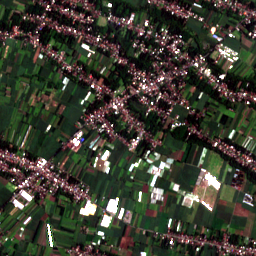

In [13]:
gambar = list(image_dir.glob('*.png'))
PIL.Image.open(str(gambar[15]))

##nama data -> csv



In [ ]:
BASE_DIR = 'images/'
train_folder = BASE_DIR+'train/'
train_annotation = BASE_DIR+'annotated_train_data/'

files_in_train = sorted(os.listdir(train_folder))
files_in_annotated = sorted(os.listdir(train_annotation))

images=[i for i in files_in_train if i in files_in_annotated]

df = pd.DataFrame()
df['images']=[train_folder+str(x) for x in images]
df['labels']=[train_annotation+str(x) for x in images]

pd.to_csv('files_path.csv', header=None)

#Data loader

##Benchmark 1 sumber: kaggel ResUnet

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=5,
                 img_h=256, img_w=256, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= image_resized.std()
            
            mask = np.empty((img_h, img_w, 1))

            # normalize Y
        y = (y > 0).astype(int)
            
        return X, y

In [ ]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [ ]:
if repeat:
    class_1_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='1')]['ImageId'].values
    class_1_img_id = np.repeat(class_1_img_id, class_1_repeat)
    train_image_ids = np.concatenate([class_1_img_id])
else:
    # split the training data into train and validation set (stratified)
    train_image_ids = train_df['ImageId'].unique()

In [ ]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [ ]:
params = {'img_h': 256,
          'img_w': 256,
          'image_dir': train_dir,
          'batch_size': batch_size,
          'shuffle': True}
# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

##Benchmark 2

In [ ]:
#Normalisasi data
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

#input data
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

#checking the data
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

##Benchmark 3 sumber: https://www.kaggle.com/mukulkr/camvid-segmentation-using-unet/notebook

In [ ]:
train_imgs = list(train_dir.glob("*.png"))
train_labels = list(train_label_dir.glob("*.png"))
val_imgs = list(val_dir.glob("*.png"))
val_labels = list(val_label_dir.glob("*.png"))
#test_imgs = list((dataset_path / "test").glob("*.png"))
#test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels))

img_size = 256

In [ ]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
#assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels);


In [ ]:
for im in train_imgs:
    assert train_label_dir / (im.stem +".png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert val_label_dir / (im.stem +".png") in val_labels , "{im} not there in label folder"
#for im in test_imgs:
    #assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [ ]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , (im.stem +".png")))
    
    return pairs

In [ ]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
#test_pair = make_pair(test_imgs, "test_labels", dataset_path)

In [ ]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

NameError: ignored

##Bechmark 4 sumber: https://github.com/matterport/Mask_RCNN/blob/v2.1/samples/balloon/balloon.py

In [ ]:
class sawah_dataset(utils.Dataset):

    def load_sawah(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("sawah", 1, "sawah")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

##bechmark 5

In [ ]:
seed = 1000 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = image_preprocessing) # custom fuction for each image you can use resnet one too.
mask_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = mask_preprocessing)  # to make mask as feedable formate (256,256,1)

image_generator =image_datagen.flow_from_directory(path_img,
                                                    class_mode=None, seed=seed)

mask_generator = mask_datagen.flow_from_directory(path_mask,
                                                   class_mode=None, seed=seed)

train_generator = zip(image_generator, mask_generator)


##Bencmark 6 sumber: https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/

In [ ]:
mask = []
img = []

for filename in image_id:
   if filename.endswith('.png'):
    img.append(filename)
   if filename.endswith('.png'):
    mask.append(filename)

img.sort()
mask.sort()
img = img[:28]
masks = mask[:28]

In [ ]:
print(img.index(1))

AttributeError: ignored

In [ ]:
index = img.index(i)

In [ ]:
y = np.zeros((28, 256,256), dtype=np.float32)
X = np.zeros((28,256, 256, 1), dtype=np.float32)

for i in enumerate(img):
  index = img.index(i)
  dir_img = os.path.join('/content/drive/My Drive/Field-Prediction/output/dataset/image', i)
  img = cv2.imread(dir_img)
  img = img.resize((256, 256))
  img = np.reshape(img, (256,256,1)) 
  X[n] = img

  mask = masks[index]
  dir_mask = os.path.join('/content/drive/My Drive/Field-Prediction/output/dataset/segmentation_mask', mask)
  mask_img = cv2.imread(dir_mask)
  mask_img = (mask!=2)*1.0  
  mask_img = cv2.resize(mask, (28, 28))
  mask_img = 1.0*(mask[:,:,0]>0.2)
  y[n] = mask

##Bechmark 7: https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [15]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sawah']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [18]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

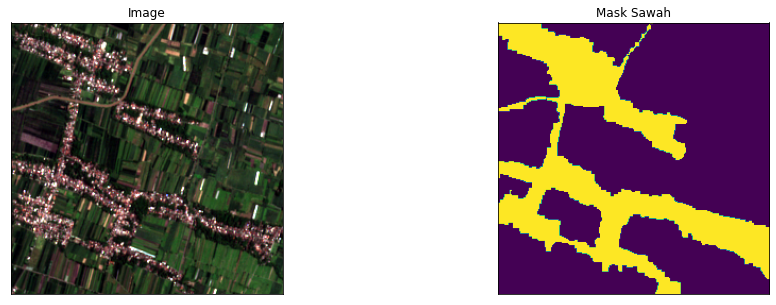

In [30]:
# Lets look at data we have
dataset = Dataset(image_dir, mask_dir, classes=['sawah'])

image, mask = dataset[16] # get some sample
visualize(
    image=image, 
    mask_sawah=mask[..., 0].squeeze(),
)

#Data Augmentations

In [31]:
import albumentations as A

In [38]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


In [39]:
# Lets look at data we have
dataset = Dataset(image_dir, mask_dir, classes=['sawah'], augmentation=get_training_augmentation())

image, mask = dataset[16] # get some sample
visualize(
    image=image, 
    mask_sawah=mask[..., 0].squeeze(),
)

AttributeError: ignored

#Model Architecture (ResUnet)

In [ ]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c


def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 1))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

#Loss Function

In [ ]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

#Compile & Run

In [ ]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

if load_pretrained_model:
    try:
        model.load_weights(pretrained_model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('You need to run the model and load the trained model')

#history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=epochs, verbose=1)

if save_model:
    model.save(model_save_path)

NameError: ignored